In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patheffects as PathEffects
from importlib import reload
from photutils.aperture import CircularAperture, CircularAnnulus
from photutils import aperture_photometry
from astropy import visualization as vis

from instrumentsim.ccd import noise, point_source as ps

In [20]:
plt.rcParams['font.size'] = 15

## 1. Simulating a star's image

In [2]:
# Bring it all together for a mock image
def mock_img(obj_counts:float, platescale:float,exptime:float = 600,
             imsize:tuple = (4096, 4112),
             x:float = None, y:float = None, fwhm:float = 1.4,
             bkg_flux:float = 150, dark:float = 3, rn:float = 3,
             sat_count:int = 200000):
    """
    Create a mock image of a point source
    on a CCD.
    Args
    ----
    obj_counts (float): Photon influx from
        object (photons/sec).
    platescale (float): arcsec/pixel at the
        image plane.
    exptime (float): exposuretime
    imsize (tuple, optional): size of the image
    x, y (float, optional): location of the point
        source. The object is placed at the
        image center by default.
    fwhm (float, optional): PSF FWHM in arcsec
    bkg_flux (float, optional): Sky background
        influx in photons/sec/arcsec^2.
    dark (float, optional): dark current in
        e-/pixel/hour.
    rn (float, optional): std.dev of read noise
        in e-
    sat_count (float, optional): Saturation
        level for each pixel. Counts beyond this
        are clipped.
    Returns
    -------
    img (ndarray): A mock CCD image.
    """

    # Prepare for image creation.
    if x is None:
        x = imsize[0]/2
    if y is None:
        y = imsize[1]/2

    # Convert FWHM to pixels
    fwhm_pix = fwhm/platescale

    # Compute object and sky levels.
    obj_lvl = obj_counts*exptime
    bkg_lvl = bkg_flux*platescale**2 # per pixel

    # Begin by creating object image
    img = ps.add_ps(x, y, fwhm_pix, obj_lvl, imsize)

    # Add sky background
    bkg = noise.sky_bkg(bkg_lvl, imsize, exptime)

    # Add dark current
    bkg += noise.dark_img(dark, imsize, exptime)

    # Apply poisson noise
    img = noise.add_poisson_noise(img+bkg)

    # Clip saturated pixels
    img = noise.saturation_clip(img, sat_count)

    # Apply read noise
    img = noise.add_read_noise(img, rn)

    # Return
    return img, bkg

### 1.1. Make the images

In [3]:
platescale = 16.5*0.015 # arcsec/pixel
star1_img, bkg_1 = mock_img(1, platescale = platescale)
star2_img, bkg_2 = mock_img(100, platescale = platescale)
star3_img, bkg_3 = mock_img(3500, platescale = platescale)
imglist = [star1_img, star2_img, star3_img]

#### Visualize

In [4]:
# Make a visulization wrapper
def draw_img(ax, fig, img, vmin=None, vmax = None,
             x = None, y = None, range = 50,
             cmap = 'hot', cblabel = None, cbticks = None,
             title = None, linstretch=False):
    """
    A wrapper for imshow
    """
    if linstretch:
        norm = None
    else:
        norm = vis.ImageNormalize(stretch=vis.LogStretch())
    im = ax.imshow(img, vmin = vmin, vmax = vmax, cmap = cmap, norm = norm)

    if x is None:
        x = img.shape[0]/2
    if y is None:
        y = img.shape[1]/2
    ax.set_xlim(x-range, x+range)
    ax.set_ylim(y-range, y+range)
    if cbticks is not None:
        cb = fig.colorbar(im, ax= ax, label = cblabel, ticks = cbticks, fraction = 0.045)
    else:
        cb = fig.colorbar(im, ax=ax, label = cblabel, fraction = 0.045)
    if title:
        ax.set_title(title)
    ax.grid(ls="--")
    return fig,ax

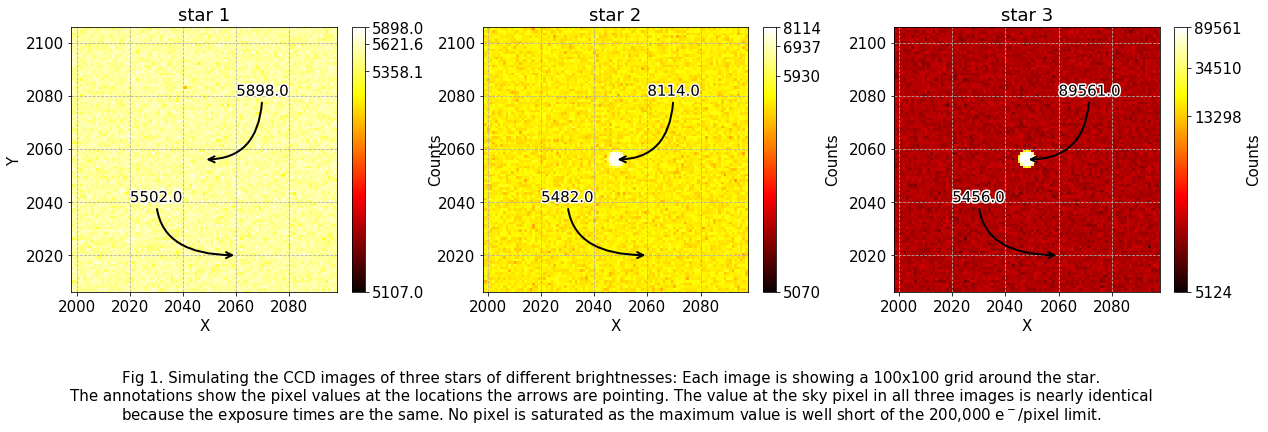

In [21]:
titles = ['star 1', 'star 2', 'star 3']

# begin plotting
fig, axs = plt.subplots(1,3,figsize=(20, 6))
fig.subplots_adjust(wspace=0.4)
axs[0].set_ylabel("Y")

for img, ax, title in zip(imglist, axs, titles):
    # get colorbar level ticks
    cb_low, cb_high = np.min(img), np.max(img)
    cbticks = np.logspace(np.log2(cb_low), np.log2(cb_high), 4, base = 2)

    # draw the image
    draw_img(ax,fig, img, cblabel = "Counts", cbticks=cbticks, title=title, range=50)

    # annotate pixels
    # Star
    ax.annotate(str(cb_high), (img.shape[0]/2, img.shape[1]/2), (2060, 2080),
                arrowprops=dict(arrowstyle="->", connectionstyle="angle3", lw=2),
                path_effects=[PathEffects.withStroke(linewidth=3,foreground="w")])
    # Random background pixel
    ax.annotate(str(img[2060, 2020]), (2060, 2020), (2020, 2040),
                arrowprops=dict(arrowstyle="->", connectionstyle="angle3", lw=2),
                path_effects=[PathEffects.withStroke(linewidth=3,foreground="w")])

    # Label
    ax.set_xlabel("X")

# add a caption
caption = r"""Fig 1. Simulating the CCD images of three stars of different brightnesses: Each image is showing a 100x100 grid around the star.
The annotations show the pixel values at the locations the arrows are pointing. The value at the sky pixel in all three images is nearly identical
because the exposure times are the same. No pixel is saturated as the maximum value is well short of the 200,000 $\rm e^-/pixel$ limit."""
fig.text(.5, -0.1, caption, ha='center')
# And show
plt.show()

## 2. Aperture photometry
I'll use `photutils.aperture_photometry` to perform my analysis here. I'll measure the total number of counts in a circular aperture containing the star and the counts in an annulus just outside the star. This will give me estimates of the stellar flux (with background noise) and the background noise (independently). I can subtract the background from the circular aperture to get an estimate of the mean stellar flux.

 In order to compute the SNR, I'll be leveraging the notion of the sum of independent random variables. We have already used this in class when we defined the formula for th SNR. Simply speaking, the sum of two numbers $(X+Y)$ drawn from independent normal distributions $N(\mu_1, \sigma_1^2), N(\mu_2, \sigma_2^2)$ is also normal $N(\mu_1+\mu_2,\sigma_1^2+\sigma_2^2)$. Now the noise is poissonian (with the exception of read noise) but all processes have averages much greater than 1, thus making the count distributions normal.

Now, when the average counts in the annulus surrounding the star is measured, it is essentially the sum of the means of the sky background, dark current and read noise. Since the read noise is small, the variance of this noise is essentially the square root of the means (thanks to the poisson distributions). The net noise variance, including the source shot noise, is simply the square root of the sum of the mean stellar flux and the noise variance. 

Thus, if $S_1$ is the total counts in the circular aperture of area $A_1$ and $S_2$ is the total counts in the surrounding annulus of area $A_2$ the signal is $S_1-S_2A_1/A_2)$ and the noise is simply $\sqrt{S_1}$ as it contains all the variances added already.
$$
\rm SNR = (S_1-S_2A_1/A_2)/\sqrt{S_1}
$$

In [6]:
# Perform simple aperture photometry
# with circular apertures for objects
# and circular_annulus for sky

def circ_aper_photom(img:np.ndarray, x:float, y:float,
                     r:float, r_ann_in:float = 15,
                     r_ann_out:float = 20):
    """
    Measures the flux within a circular aperture
    and estimates the SNR using the
    local sky background flux estimated using
    an annulus. Assumes a sky dominated
    background level.
    Args
    ----
    img (ndarray): 2D image 
    x, y (float): location in pixels.
    r (float): radius of aperture in pixels
    r_ann_in, r_ann_out (float, optional): Sky annulus
        inner and outer radii in pixels.
    Returns
    -------
    phot_table (astropy Table): Summary table
        of aperture photometry results.
    """
    circ_aper = CircularAperture((x, y), r)
    sky_annulus = CircularAnnulus((x, y), r_ann_in, r_ann_out)
    apers = [circ_aper, sky_annulus]

    phot_table = aperture_photometry(img, apers)

    # Compute sky subtracted flux

    bkg_counts = phot_table['aperture_sum_1']/sky_annulus.area*circ_aper.area # This is the background flux estimated in the star aperture
    phot_table['object_flux'] = phot_table['aperture_sum_0']-bkg_counts

    phot_table['bkg_flux'] = bkg_counts

    # Compute SNR
    phot_table['SNR'] = phot_table['object_flux']/np.sqrt(phot_table['aperture_sum_0'])
    return phot_table

In [7]:
star_x, star_y = star1_img.shape[0]/2, star1_img.shape[1]/2 # Star centroid
radius = 0.7/platescale # Radius of the aperture
photom_1 = circ_aper_photom(star1_img, star_x, star_y, radius)
photom_1

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,object_flux,bkg_flux,SNR
,pix,pix,,,,,
int64,float64,float64,float64,float64,float64,float64,float64
1,2048.0,2056.0,138792.85192962128,3033733.471437601,122.04331784235546,138670.80861177892,0.3275898641035115


In [8]:
photom_2 = circ_aper_photom(star2_img, star_x, star_y, radius)
photom_2

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,object_flux,bkg_flux,SNR
,pix,pix,,,,,
int64,float64,float64,float64,float64,float64,float64,float64
1,2048.0,2056.0,192391.1580074266,3032213.655710442,53789.819597236,138601.3384101906,122.63305103868403


In [9]:
photom_3 = circ_aper_photom(star3_img, star_x, star_y, radius)
photom_3

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,object_flux,bkg_flux,SNR
,pix,pix,,,,,
int64,float64,float64,float64,float64,float64,float64,float64
1,2048.0,2056.0,2001003.0000898885,3034055.4148797765,1862317.4755652337,138685.52452465464,1316.527237838244


Since I know the background really well, I can compare the measured values to the theoretical estimates.

Theoretical source count estimate:
$$
\rm S_{source} = F\times600
$$
Where $\rm F$ is the photon flux. Indeed, all three cases show `object_flux` close to this value.

Theoretical average sky background counts in the aperture:
$$
\rm S_{sky} = 150\times(\pi 0.7^2)\times600=138544~e^-
$$

Theoretical average dark count estimate:
$$
\rm S_{dark} = 3\times(600/3600)\times(\pi 0.7^2)/(0.2475)^2=12.6~e^-
$$

Therefore the average background estimate is $138557~e^-$. That's pretty close to the `bkg_flux` estimated in all three cases above.

We're reading 37 pixels in the aperture and the read noise variance is threfore $3^2\times37=333~e^-$. The net variance is $600F+138900~e^-$ and the standard deviation is $372\times\sqrt{1+600F/138900}$. For the three cases, the SNR values expected are:
$$
\begin{aligned}
F=1&\Rightarrow SNR=1.6\\
F=100&\Rightarrow SNR=135\\
F=3500&\Rightarrow SNR=1403\\
\end{aligned}
$$
And that's roughly what we see in the `SNR` columns.

## 3. Any saturations?
The maximum number of counts in the images are shown in Fig 1. None of them are above the full well depth of $200000~e^-$ and therefore, no image is saturated. If any were saturated, the simplest way to simulate is what is implemented in my current repository (as of Apr 13 2020). I've just asked the counts to be clipped at 200,000. More complicated simulation will require a thorough understanding of the CCD.

## 4. SNR per pixel.
To define an SNR at each pixel, one must first define what a "signal" is at each pixel. One way to do it would be to determine the theoretical std.dev. at each pixel and define the SNR as just the pixel counts subtracted from the mean background divided by this theoretical value.

In [12]:
# Define a function to compute this
def snr_image(img:np.ndarray, obj_counts:float, platescale:float=0.2475,
              exptime:float = 600, x:float = 2048, y:float = 2056, fwhm:float = 1.4,
             bkg_flux:float = 150, dark:float = 3, rn:float = 3):
    """
    Create an image of the theoretical per pixel SNR
    for a supplied mock CCD image. 
    Args
    ----
    img (ndarray): 2D image whose SNR is to be
        computed.
    obj_counts (float): Photon influx from
        object (photons/sec).
    platescale (float): arcsec/pixel at the
        image plane.
    exptime (float): exposuretime
    imsize (tuple, optional): size of the image
    x, y (float, optional): location of the point
        source. The object is placed at the
        image center by default.
    fwhm (float, optional): PSF FWHM in arcsec
    bkg_flux (float, optional): Sky background
        influx in photons/sec/arcsec^2.
    dark (float, optional): dark current in
        e-/pixel/hour.
    rn (float, optional): std.dev of read noise
        in e-
    sat_count (float, optional): Saturation
        level for each pixel. Counts beyond this
        are clipped.
    Returns
    -------
    snr_img (ndarray): A mock CCD image.
    stddev_img (ndarray): The theoretical STDDEV at each pixel
    """
    # Convert FWHM to pixels
    fwhm_pix = fwhm/platescale

    # Compute object and sky levels.
    obj_lvl = obj_counts*exptime
    bkg_lvl = bkg_flux*platescale**2 # per pixel
    imsize = img.shape

    #import pdb; pdb.set_trace()
    # Begin by creating theoretical object image
    theoretical_img = ps.add_ps(x, y, fwhm_pix, obj_lvl, imsize)

    # Make bkg image
    bkg_img = noise.sky_bkg(bkg_lvl, imsize, exptime)

    # Add dark current
    bkg_img += noise.dark_img(dark, imsize, exptime)

    # Add read noise and compute std. dev
    bkg_img += rn
    stddev_img = np.sqrt(theoretical_img+bkg_img)

    snr_img = (img-bkg_img+rn)/stddev_img # adding rn because its mean is 0.
    return snr_img, stddev_img

In [18]:
snr1, std1 = snr_image(star1_img, 1)
snr2, std2 = snr_image(star2_img, 100)
snr3, std3 = snr_image(star3_img, 3500)
snrimglist = [snr1,snr2,snr3]

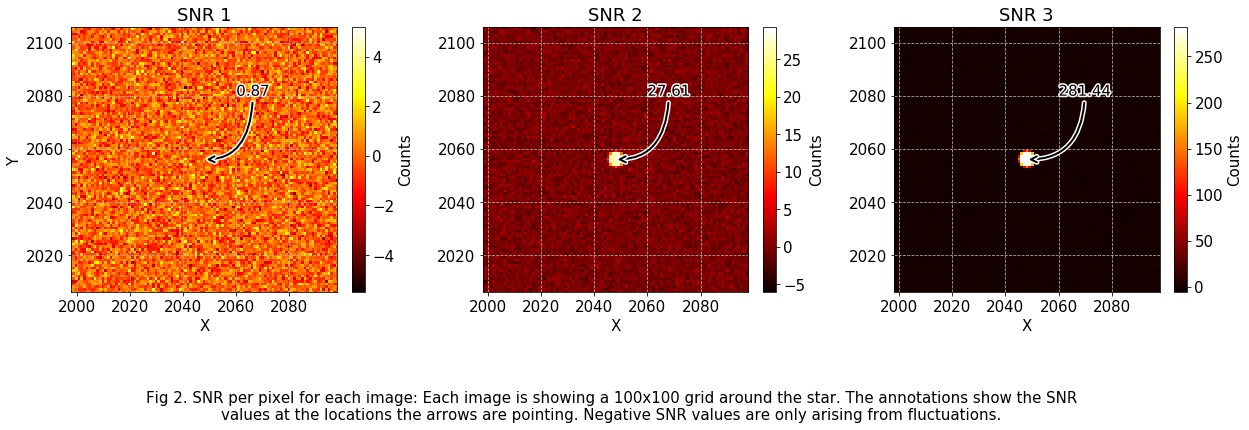

In [23]:
titles = ['SNR 1', 'SNR 2', 'SNR 3']

# begin plotting
fig, axs = plt.subplots(1,3,figsize=(20, 6))
fig.subplots_adjust(wspace=0.4)
axs[0].set_ylabel("Y")

for img, ax, title in zip(snrimglist, axs, titles):
    # Draw the images
    draw_img(ax,fig, img, cblabel = "Counts", title=title, range=50, linstretch=True)

    # Add annotations
    txt = ax.annotate("{:0.2f}".format(img[int(img.shape[1]/2), int(img.shape[0]/2)]),(img.shape[0]/2, img.shape[1]/2), (2060, 2080),
                arrowprops=dict(arrowstyle="->", connectionstyle="angle3", lw=2),
                path_effects=[PathEffects.withStroke(linewidth=3,foreground="w")])

    # Make arrow visible against background
    txt.arrow_patch.set_path_effects([PathEffects.Stroke(linewidth=5, foreground="w"),PathEffects.Normal()])

    # Set X axis label
    ax.set_xlabel("X")

# Add a caption
caption = r"""Fig 2. SNR per pixel for each image: Each image is showing a 100x100 grid around the star. The annotations show the SNR
values at the locations the arrows are pointing. Negative SNR values are only arising from fluctuations."""
fig.text(.5, -0.1, caption, ha='center')

# And show
plt.show()

## 5. Total SNR for each star
I suppose this refers to the sum of the signal in the star's pixels divided by the net standard deviation combining all those pixels. I can compute this using an aperture sum for the image and the stddev.

In [72]:
# Define aperture
circaper = CircularAperture((2048, 2056), 0.7/platescale)

# Prepare images
signal1 = snr1*std1
signal2 = snr2*std2
signal3 = snr3*std3

# Compute aperture sums
sigsum1 = aperture_photometry(signal1, circaper)['aperture_sum']
varsum1 = aperture_photometry(std1**2, circaper)['aperture_sum']

sigsum2 = aperture_photometry(signal2, circaper)['aperture_sum']
varsum2 = aperture_photometry(std2**2, circaper)['aperture_sum']

sigsum3 = aperture_photometry(signal3, circaper)['aperture_sum']
varsum3 = aperture_photometry(std3**2, circaper)['aperture_sum']

siglist = [sigsum1, sigsum2, sigsum3]
varlist = [varsum1, varsum2, varsum3]

# Compute the net SNR for the three cases
for num, (sig, var) in enumerate(zip(siglist, varlist)):
    print("The net SNR for star {:d} is {:0.2f}".format(num+1, sig.data[0]/np.sqrt(var.data[0])))

The net SNR for star 1 is 1.77
The net SNR for star 2 is 122.32
The net SNR for star 3 is 1313.95


## 6. A different focal plane scale.
If the image had Keck's focal plane scale of 0.727 arcsec/mm, the star's PSF would cover many more pixels. This scales up the net read noise in an aperture sum while keeping the sky background value the same (asusming that the PSF remains the same angular size). It would roughly scale up by a factor of $(16.5/0.727)^2=515$. From my estimate of $333~e^-$ from Q.2, the net read noise would shoot up to $171530~e^-$, making it larger than the sky background for a 600 s exposure.

The total dark current noise would also increase by the same factor to $6500~e^-$. This is still negligible compared to the other sources. 
 The total std.dev in the counts for each of the stars would then become: $556\times\sqrt{1+600F/310100}$. This means their SNRs would be:
$$
\begin{aligned}
F=1&\Rightarrow SNR=1.07\\
F=100&\Rightarrow SNR=98\\
F=3500&\Rightarrow SNR=1352\\
\end{aligned}
$$

## 7. Measuring sky background separately
If the sky background were estimated using a different exposure than the object, the SNr estimations would have ot be done differently. Let's assume the background count is sky dominated. This is certianly true for all the images considered here. For star 2, a 600 s exposure would give an average signal of 60000 counts. If a 60 s exposure is taken for the sky, its mean and std.dev would theoretically be $150\times60\times(0.7^2\pi) = 13854~e^-$ and $\sqrt{13854}=117$. This corresponds to a an uncertainty of 0.8% for the background. The shot noise of the star adds a 0.4% uncertainty on the measured counts. Thus, the total uncertainty in the star's flux is 1.2%.

If the sky were measured using a 3600 s exposure, its uncertainty would fall by a factor of $\sqrt{60}$ to 0.1%. Thus the net uncertainty in the star's flux would be 0.5%. This is a factor of 2.4 improvement in the SNR. If I were asked to choose anexposure time for the sky when using such an observation scheme, I'd take a short exposure of the sky, compute the mean and then compute the required exposure time for my SNR goal. If this time is too long (I can't burn too many taxpayer dollars, can I?), I'd have to make do with a lower SNR.  